In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [49]:
customers_df = pd.read_csv("Customers.csv")  
products_df = pd.read_csv("Products.csv")  
transactions_df = pd.read_csv("Transactions.csv")  

In [50]:
# Combine Customers and Transactions Data

In [51]:
transactions_merged = transactions_df.merge(products_df, on='ProductID', how='left')


In [52]:
# Aggregate transaction data for customers
transaction_summary = transactions_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price_y': 'mean',
    'Category': lambda x: ','.join(x.unique())
}).reset_index().rename(columns={'Price_y': 'AveragePrice'})

In [53]:
customer_profiles = customers_df.merge(transaction_summary, on='CustomerID', how='left')
customer_profiles[['TotalValue', 'Quantity', 'AveragePrice']] = customer_profiles[['TotalValue', 'Quantity', 'AveragePrice']].fillna(0)

In [54]:
# Encode Regions (One-Hot Encoding)
region_encoder = OneHotEncoder(sparse=False)  
region_encoded = region_encoder.fit_transform(customers_df[['Region']])  

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [55]:
# Prepare features for clustering
features = np.hstack([region_encoded,customer_profiles[['TotalValue', 'Quantity', 'AveragePrice']].values])

In [59]:
# Initialize the StandardScaler
scaler = StandardScaler()

In [60]:
# Normalize features for clustering
features_scaled = scaler.fit_transform(features)

In [61]:
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(features_scaled)



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

In [66]:
# Evaluate using DB Index and Silhouette Score
db_index = davies_bouldin_score(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)
results.append({'n_clusters': n_clusters,'DB_Index': db_index,'Silhouette_Score': silhouette_avg})

In [67]:
# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results)

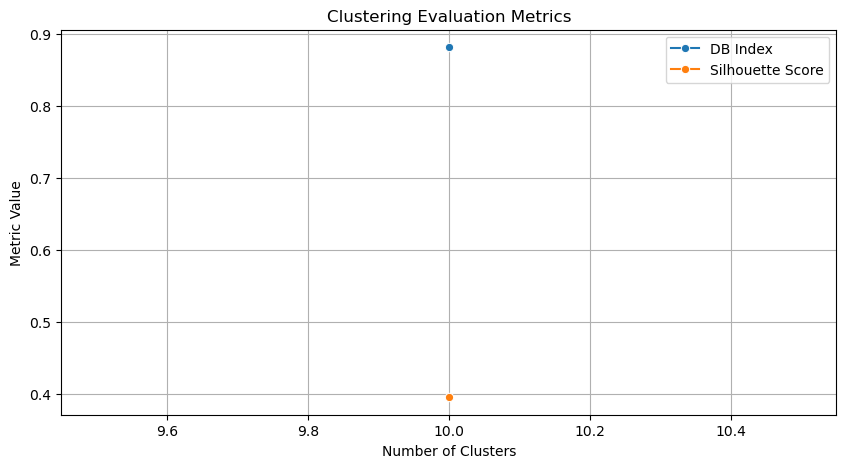

In [68]:
# Visualize the metrics
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_df, x='n_clusters', y='DB_Index', marker='o', label='DB Index')
sns.lineplot(data=results_df, x='n_clusters', y='Silhouette_Score', marker='o', label='Silhouette Score')
plt.title('Clustering Evaluation Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

In [69]:
optimal_clusters = results_df.loc[results_df['DB_Index'].idxmin(), 'n_clusters']

In [70]:
# Run K-Means with the optimal number of clusters
kmeans_final = KMeans(n_clusters=int(optimal_clusters), random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(features_scaled)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [71]:
# Add cluster labels to the customer profiles
customer_profiles['Cluster'] = final_labels

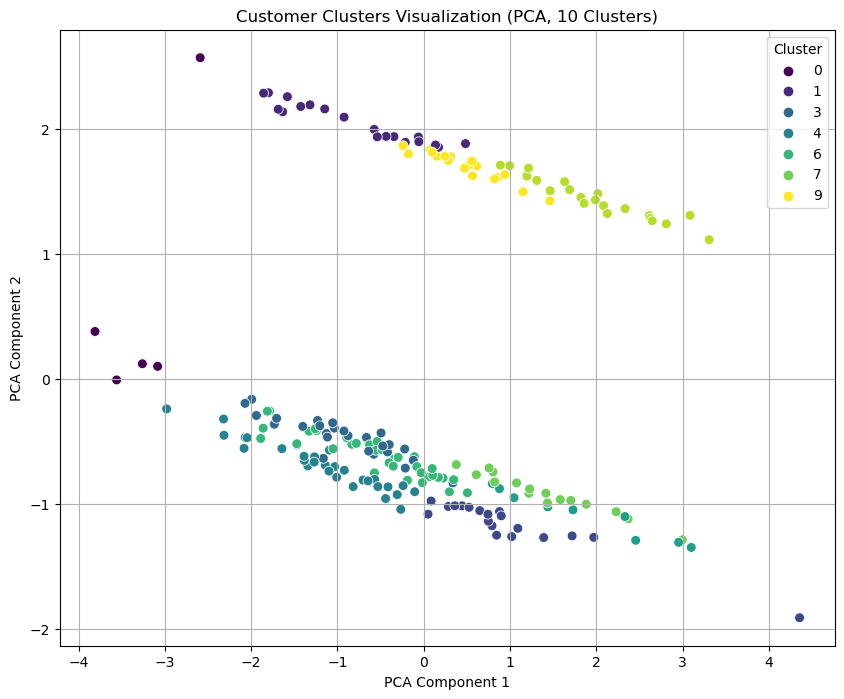

In [72]:
# Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=features_pca[:, 0], y=features_pca[:, 1], 
    hue=customer_profiles['Cluster'], palette='viridis', s=50
)
plt.title(f'Customer Clusters Visualization (PCA, {optimal_clusters} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



In [78]:
#Save clustering results to a CSV
clustering_csv_path = "/mnt/data/Customer_Segmentation.csv"
customer_profiles[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation.csv', index=False)

In [79]:
results_df, optimal_clusters, clustering_csv_path

(   n_clusters  DB_Index  Silhouette_Score
 0          10  0.881578          0.395575,
 10,
 '/mnt/data/Customer_Segmentation.csv')